# WECC Temperature Maps for Heat Wave Study

In [1]:
# Start by importing the packages we need:
import os
import glob

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable


## Set the Directory Structure

In [2]:
# Identify the data input and output directories:
weather_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/wrf_tell_counties_output/historic/'
metadata_input_dir =  '/Users/burl878/Documents/IMMM/Data/Random/ERCOT_Heat_Wave_Cold_Snap_Figure//'
data_output_dir = '/Users/burl878/Documents/Code/code_repos/wecc_proof_of_concept/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/wecc_proof_of_concept/plots/'


## Set the Plot Constraints

In [3]:
# Set the year you want to analyze:
year_to_process = 2018

# Set the lat/lon bounds for the plot:
lat_min = 24
lat_max = 49.75
lon_min = -125.5
lon_max = -66.5

# Set the minimum and maximum temperatures for the colorbar:
heat_t_min = 60
heat_t_max = 115

# Set the projection/CRS you want to use (e.g., https://en.wikipedia.org/wiki/Spatial_reference_system):
projection = "EPSG:4269"


## Read in the Shapefiles


In [4]:
# Read in the county shapefile and reassign the 'FIPS' variable as integers:
counties_df = gpd.read_file(os.path.join(metadata_input_dir, r'County_Shapefiles', r'tl_2020_us_county.shp')).rename(columns={'GEOID': 'FIPS'})
counties_df['FIPS'] = counties_df['FIPS'].astype(int)

# Read in the state shapefile:
states_df = gpd.read_file(os.path.join(metadata_input_dir, r'State_Shapefiles', r'tl_2020_us_state.shp'))

# Change the CRS to match the projection you want to use:
counties_df = counties_df.to_crs(projection)
states_df = states_df.to_crs(projection)


## Process the Maximum Temperature During the Heat Wave


In [5]:
# Check to see if the processed output file exist and if not then create it:
if os.path.isfile((os.path.join(data_output_dir, ('Heat_Wave_T_Max_' + str(year_to_process) + '.csv')))) == False:
   if year_to_process == 2017:
      start_day = pd.to_datetime('2017-08-26 00:00:00')
      end_day = pd.to_datetime('2017-09-04 00:00:00')
   if year_to_process == 2018:
      start_day = pd.to_datetime('2018-07-22 00:00:00')
      end_day = pd.to_datetime('2018-07-28 00:00:00')
   
   # Create a list of all county meteorology files in the input directory:
   list_of_files = sorted(glob.glob(os.path.join(weather_data_input_dir, str(year_to_process), '*.csv')))
   
   # Aggregate the county level data across all file:
   county_df = pd.concat((pd.read_csv(f).assign(Time_UTC=os.path.basename(f)) for f in list_of_files))
   county_df['Time_UTC'] = pd.to_datetime(county_df.Time_UTC, exact=False, format='%Y_%m_%d_%H')
    
   # Subset to just the files in the time window:
   county_df = county_df.loc[(county_df['Time_UTC'] >= start_day) & (county_df['Time_UTC'] <= end_day)]
    
   # Find the max T2 value by county:
   temp_df = pd.DataFrame(county_df.groupby('FIPS')['T2'].max())
    
   # Convert the temperatures from Kelvin to Fahrenheit:
   temp_df['T2'] = (1.8 * (temp_df['T2'] - 273)) + 32
   temp_df['T2'] = temp_df['T2'].round(2)
   
   # Write out the dataframe to a .csv file:
   temp_df.to_csv((os.path.join(data_output_dir, ('Heat_Wave_T_Max_' + str(year_to_process) + '.csv'))), sep=',', index=True)
   
else:
   # Read in the already processed output file:
   temp_df = pd.read_csv((os.path.join(data_output_dir, ('Heat_Wave_T_Max_' + str(year_to_process) + '.csv'))))


In [6]:
# Merge the temperature and shapefiles dataframes together:
heat_df = counties_df.merge(temp_df, on='FIPS', how='left')


## Make the Heat Wave Plot


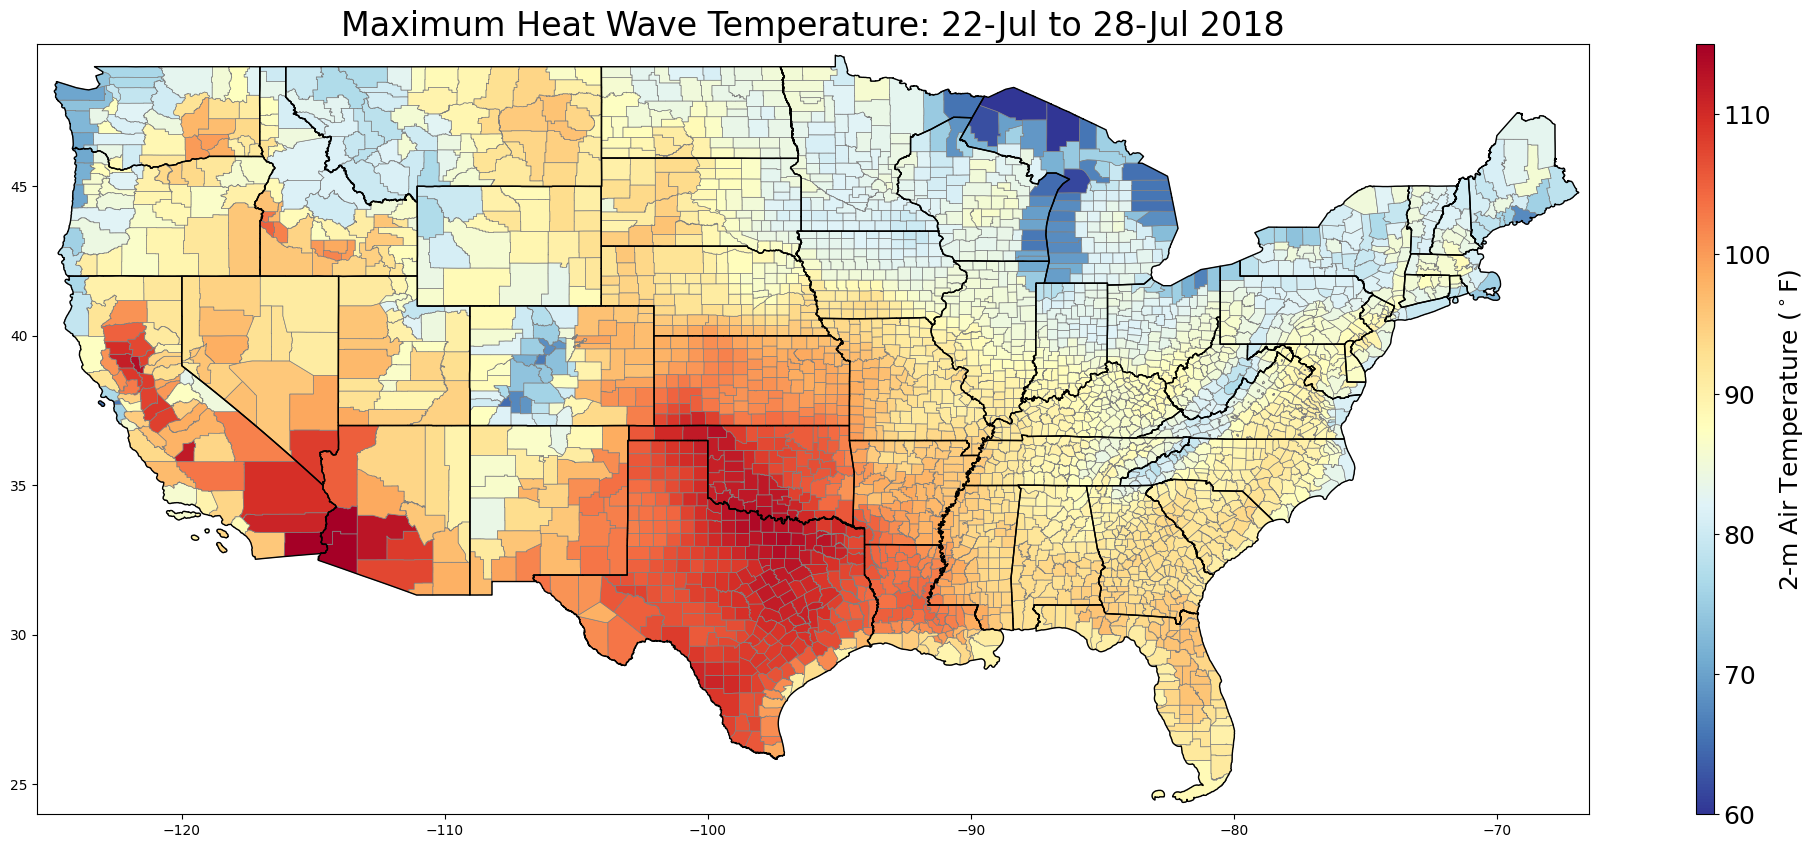

In [7]:
# Make the plot:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
plt.rcParams['font.size'] = 18
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.01)
heat_df.plot(ax = ax, 
             cax = cax, 
             column = 'T2', 
             cmap = 'RdYlBu_r', 
             vmin = heat_t_min, 
             vmax = heat_t_max,
             edgecolor = 'grey', 
             linewidth = 0.5, 
             legend = True, 
             legend_kwds = {'label': ('2-m Air Temperature ($^\circ$F)'), 'orientation': 'vertical'})
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
if year_to_process == 2017:
   ax.set_title(('Maximum Heat Wave Temperature: 26-Aug to 3-Sep 2017'), fontsize = 24)
if year_to_process == 2018:
   ax.set_title(('Maximum Heat Wave Temperature: 22-Jul to 28-Jul 2018'), fontsize = 24)

# Overlay the state boundaries:
states_df.plot(ax = ax, facecolor = 'none', edgecolor = 'black', linewidth = 1, zorder = 2)
    
# Save the figure:
plt.savefig(os.path.join(image_output_dir, (str(year_to_process) + '_Heat_Wave.png')), dpi=300, bbox_inches='tight', facecolor='white')
